# Islamophhobia Detection with BERT using Keras and TensorFlow 2

In [1]:
!nvidia-smi

Tue Sep 15 01:59:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install tensorflow-gpu 

     |████████████████████████████████| 320.4MB 55kB/s 


In [3]:
!pip install --upgrade grpcio

Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.32.0)


In [4]:
!pip install tqdm

In [5]:
!pip install bert-for-tf2

     |████████████████████████████████| 40kB 4.0MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.6-cp36-none-any.whl size=30318 sha256=3cd05e3adc62d14dede258276526888f8b62a6679d6a8b7bb02db02e890e0d49
  Stored in directory: /root/.cache/pip/wheels/07/a0/b4/75b0601ebaa41e517a797fe9cea119c789664c8408f8a74ae9
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7304 sha256=b5ae1c6640eac38f4f10e63e2b08532abddd5c7cc438060cf82f495995586910
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=4d8ed3972c0a37883662a1ef006384d0b2300ee71ccd2501a4165012c2a814fb
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
!pip install googletrans

     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 962kB 15.2MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=bec16a20b88f1645cbb1b302ba0ea6f2ed098bb1b50e5565895b5ca797c6ee13
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=0a3b5a7824dd259164b4f12fcea5d5837d0f6439d1b1c16516daff1061e31030
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [7]:
!pip install sentencepiece

     |████████████████████████████████| 1.1MB 8.7MB/s 


In [48]:
!pip install googletrans

In [8]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report

import re

# translator
import googletrans
from googletrans import Translator

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data


In [9]:
# English data
!gdown --id 1T46vo1HvVfgT7dVkZwKe3AB9LMjPJ4UD --output data-task2.csv

Downloading...
From: https://drive.google.com/uc?id=1T46vo1HvVfgT7dVkZwKe3AB9LMjPJ4UD
To: /content/data-task2.csv
100% 815k/815k [00:00<00:00, 109MB/s]


In [10]:
df = pd.read_csv('data-task2.csv', 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head(15)
df["Text"] = df["Text"].astype(str)
df["Label"] = df["Label"].astype(str)

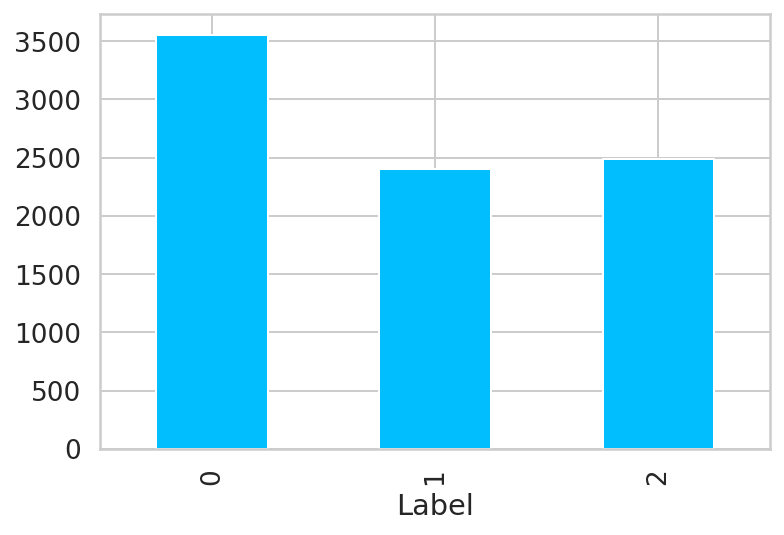

In [11]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [12]:

# For entire dataset sentences for each labels 
df.Label.value_counts()

0    3555
2    2485
1    2398
Name: Label, dtype: int64

In [13]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [14]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [15]:
data_df = pd.DataFrame(new_text)
data_df.columns = ['Text']
data_df['Label'] = new_label
data_df = pd.concat([df, data_df])

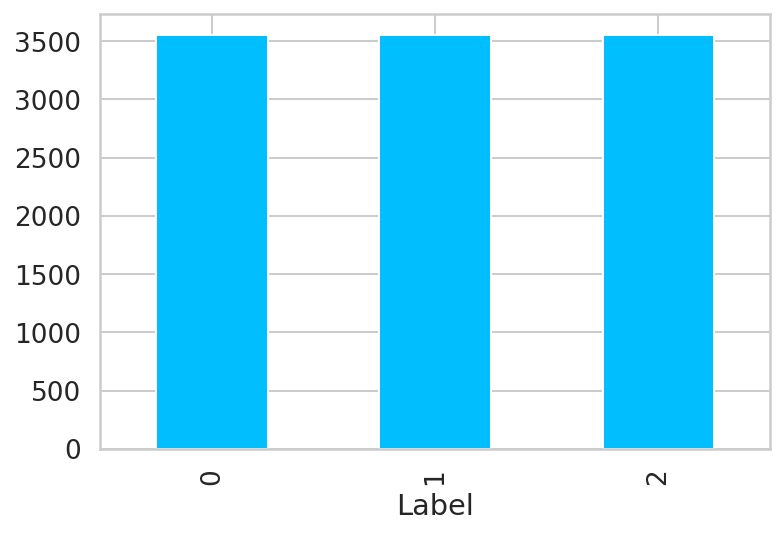

In [16]:
fig1 = plt.figure(figsize=(6,4))
data_df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [17]:
df = data_df

In [18]:
df.Label.value_counts()

0    3555
2    3554
1    3554
Name: Label, dtype: int64

In [19]:
df=df.sample(frac=1).reset_index(drop=True)
df

,Text,Label
0,'@OpIndia_com @myogiadityanath pls order encou...,2
1,'@hollandcourtney @RashidaTlaib Ohhhhh letâ€™s...,2
2,"""HAPPY HIJRAH TO ALL MUSLIM BROTHER'S &amp SI...",1
3,"'WizComic official blog: ""Cricket Boy"" Introdu...",0
4,'Fuck you all radical Islamist you are a threa...,2
...,...,...
10658,'emilee and I cried over a cricket today and i...,0
10659,'Happy new Islamic year to everyone- 1st Muhar...,1
10660,'@chedetofficial Elephant walks DOGs bark. Ke...,2
10661,'Training sessions in Sri Lanka to hold sway i...,0


Data Preprocessing

In [20]:
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

df['Text'] = df['Text'].apply(lambda x: ReplaceFourColon(x))

In [21]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

df['Text'] = df['Text'].apply(lambda x: textPattern(x))

In [22]:
df = df[df.Text != '']

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.10, random_state=42)

In [24]:
df.head()

,Text,Label
0,OpIndia com myogiadityanath pls order encount...,2
1,hollandcourtney RashidaTlaib Ohhhhh let s rid...,2
2,HAPPY HIJRAH TO ALL MUSLIM BROTHER S amp SIST...,1
3,WizComic official blog : Cricket Boy Introduc...,0
4,Fuck you all radical Islamist you are a threa...,2


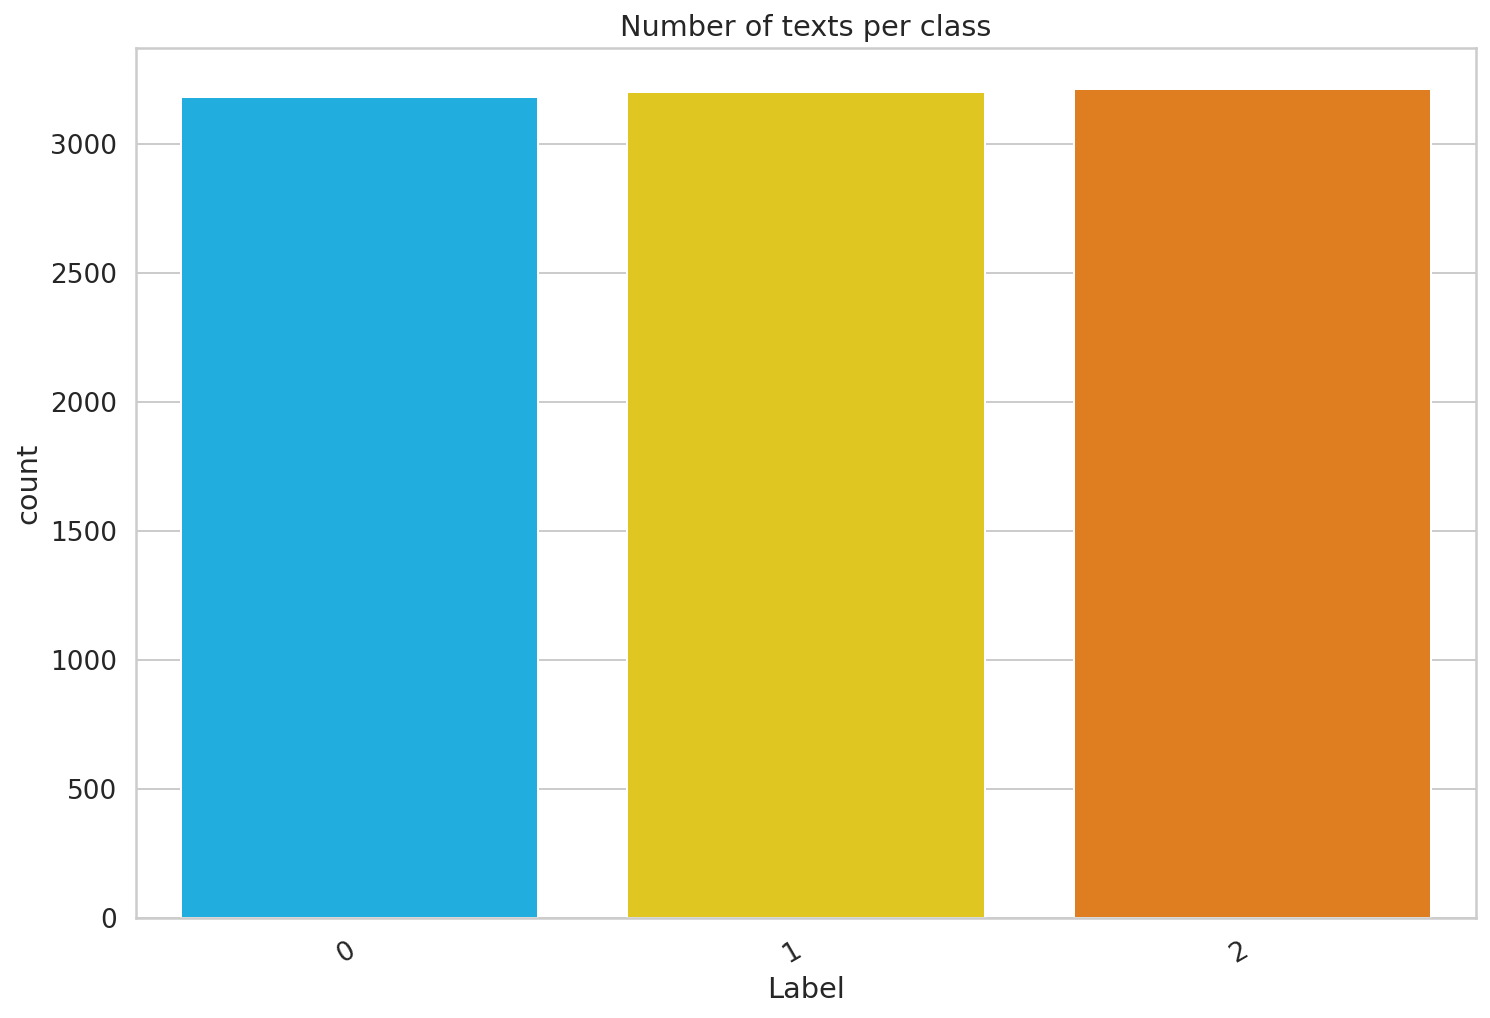

In [25]:
chart = sns.countplot(train.Label, palette=HAPPY_COLORS_PALETTE)
plt.title("Number of texts per class")
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right');

# Islamophhobia Detection with BERT


In [26]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-09-15 02:00:09--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  91.0MB/s    in 4.3s    

2020-09-15 02:00:15 (91.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]



In [27]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [28]:
os.makedirs("model", exist_ok=True)

In [29]:
!mv uncased_L-12_H-768_A-12/ model

In [30]:
bert_model_name="uncased_L-12_H-768_A-12"

bert_ckpt_dir = os.path.join("model/", bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json")

## Preprocessing

In [31]:
class IslamophobiaDetectionData:
  DATA_COLUMN = "Text"
  LABEL_COLUMN = "Label"

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes
    
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    print("max seq_len", self.max_seq_len)
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []
    
    for _, row in tqdm(df.iterrows()):
      text, label = row[IslamophobiaDetectionData.DATA_COLUMN], row[IslamophobiaDetectionData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      x.append(token_ids)
      y.append(self.classes.index(label))

    return np.array(x), np.array(y)

  def _pad(self, ids):
    x = []
    for input_ids in ids:
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)

In [32]:
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))

In [33]:
def create_model(max_seq_len, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, "r") as reader:
      bc = StockBertConfig.from_json_string(reader.read())
      bert_params = map_stock_config_to_params(bc)
      bert_params.adapter_size = None
      bert = BertModelLayer.from_params(bert_params, name="bert")
        
  input_ids = keras.layers.Input(shape=(max_seq_len, ), dtype='int32', name="input_ids")
  bert_output = bert(input_ids)

  #print("bert shape", bert_output.shape)

  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation="tanh")(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)

  logits = keras.layers.Dense(units=len(classes), activation="softmax")(logits)


  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)
  
  model.compile(
  optimizer=keras.optimizers.Adam(1e-5),
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
)
        
  return model

## Training

In [34]:
classes = train.Label.unique().tolist()

data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)

9596it [00:03, 2674.91it/s]
1067it [00:00, 2789.58it/s]


max seq_len 338


In [35]:
model = create_model(data.max_seq_len, bert_ckpt_file)

Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5c07bac4a8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [36]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 128)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 128, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

In [37]:
history = model.fit(
  x=data.train_x, 
  y=data.train_y,
  validation_split=0.1,
  batch_size=16,
  shuffle=True,
  epochs=5
)

Epoch 1/5
540/540 [==============================] - 246s 455ms/step - loss: 0.7954 - acc: 0.7319 - val_loss: 0.6087 - val_acc: 0.9406
Epoch 2/5
540/540 [==============================] - 244s 452ms/step - loss: 0.6010 - acc: 0.9507 - val_loss: 0.5871 - val_acc: 0.9635
Epoch 3/5
540/540 [==============================] - 244s 451ms/step - loss: 0.5894 - acc: 0.9619 - val_loss: 0.5858 - val_acc: 0.9656
Epoch 4/5
540/540 [==============================] - 244s 451ms/step - loss: 0.5849 - acc: 0.9667 - val_loss: 0.5896 - val_acc: 0.9625
Epoch 5/5
540/540 [==============================] - 244s 453ms/step - loss: 0.5826 - acc: 0.9690 - val_loss: 0.5775 - val_acc: 0.9740


## Evaluation

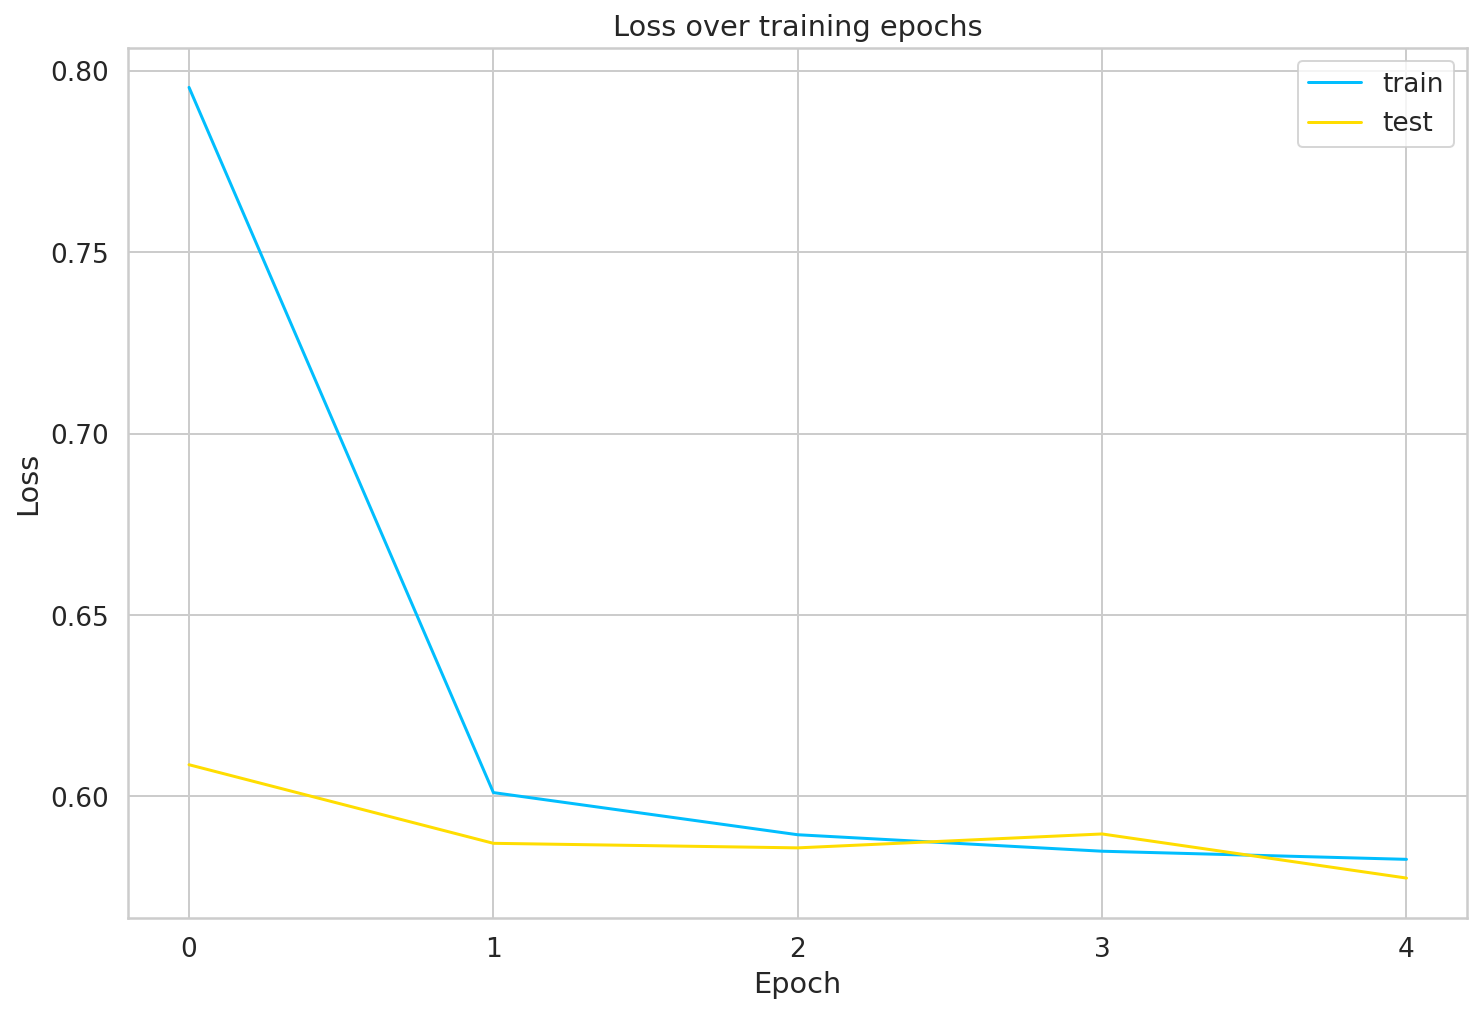

In [38]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

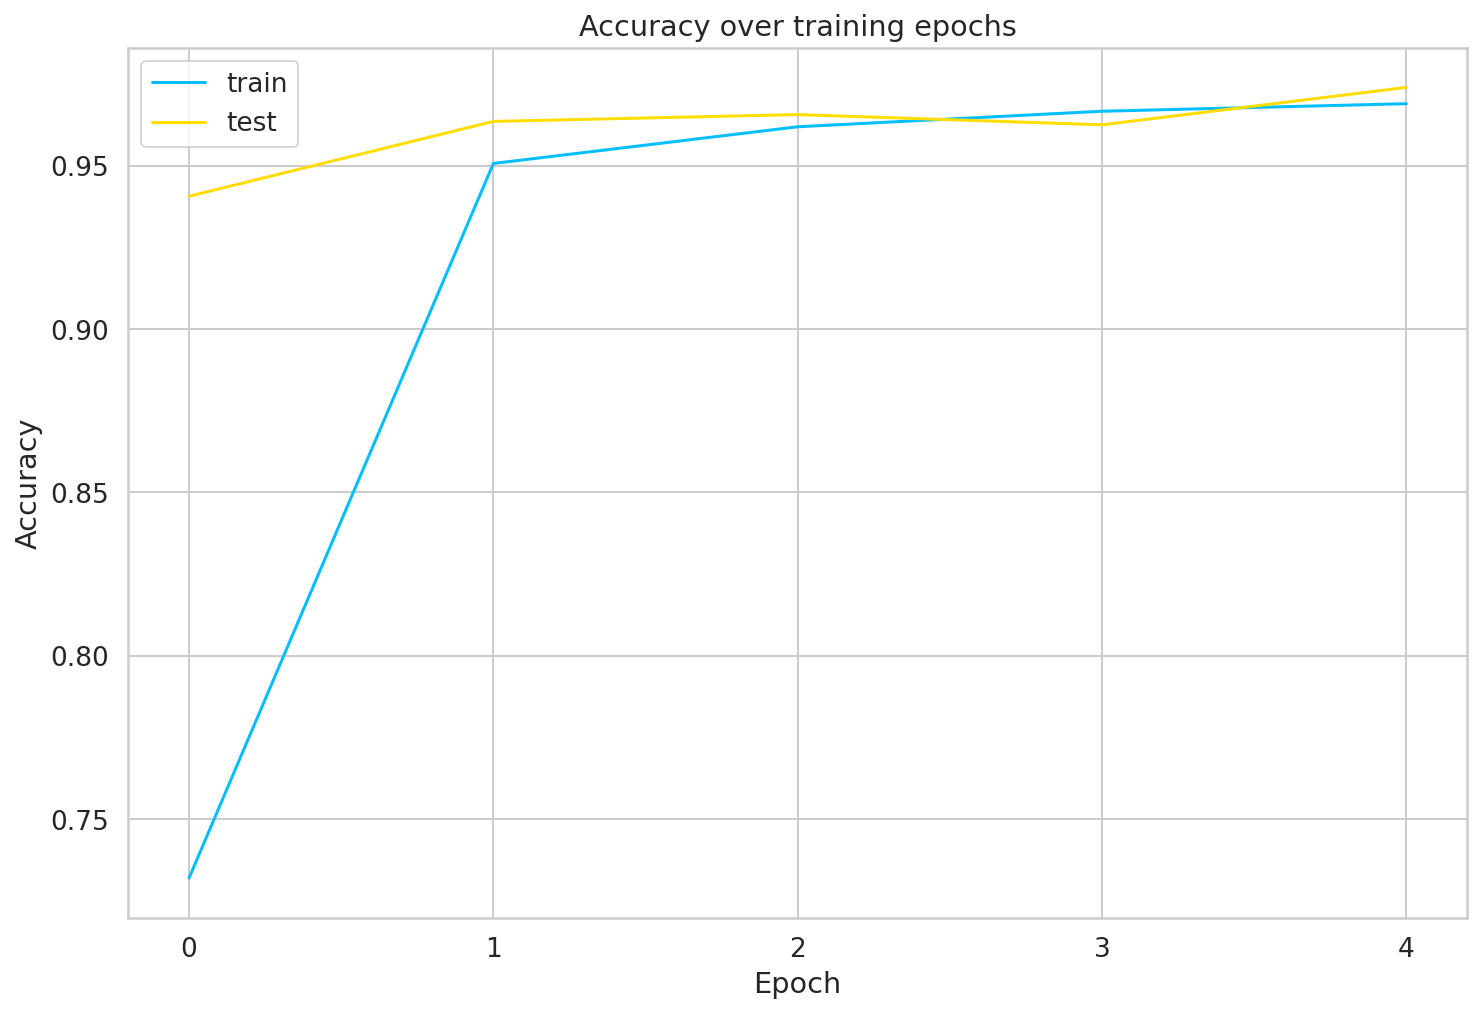

In [39]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['acc'])
ax.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Accuracy over training epochs')
plt.show();

In [40]:
_, train_acc = model.evaluate(data.train_x, data.train_y)
_, test_acc = model.evaluate(data.test_x, data.test_y)

print("train acc", train_acc)
print("test acc", test_acc)

34/34 [==============================] - 6s 169ms/step - loss: 0.5963 - acc: 0.9560
train acc 0.9760316610336304
test acc 0.9559512734413147


In [41]:
y_pred = model.predict(data.test_x).argmax(axis=-1)

In [42]:
print(classification_report(data.test_y, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       351
           1       0.92      0.97      0.94       342
           2       0.99      0.97      0.98       374

    accuracy                           0.96      1067
   macro avg       0.96      0.96      0.96      1067
weighted avg       0.96      0.96      0.96      1067



In [43]:

cm = confusion_matrix(data.test_y, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)

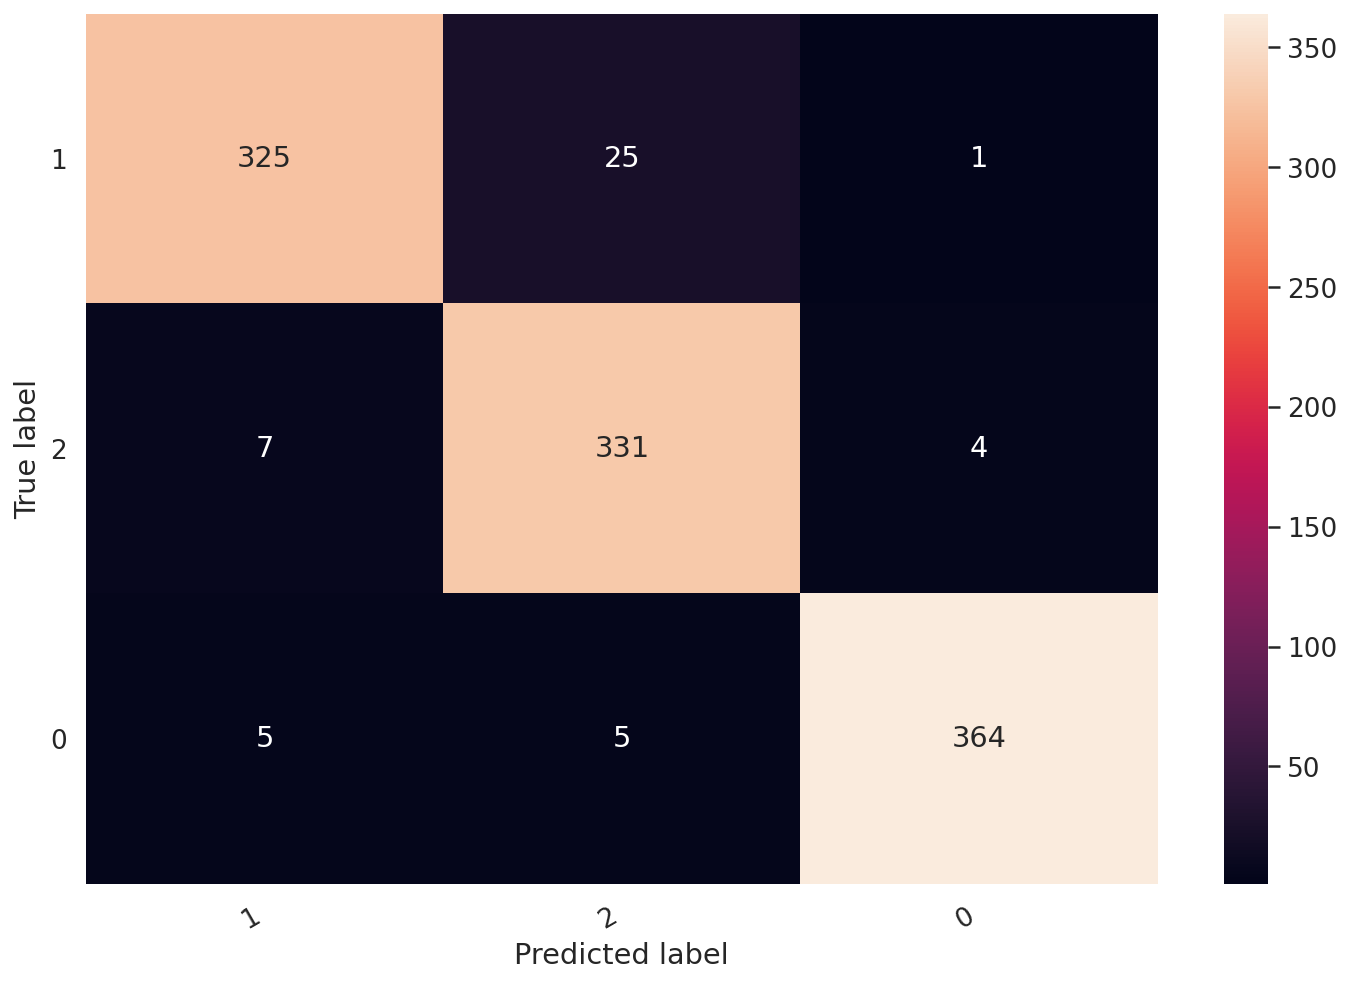

In [44]:
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# 10 Fold cross validation

In [45]:
import random
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

kFold = 10

#To get accuracy of the model for 10 different splits
scores = []
training_accuracy = []
testing_accuracy = []
print("BERT: ")
for i in range(kFold):
    print('Fold ', i+1)
    print('')
    # Splitting data into test and train
    train, test = train_test_split(df, test_size=0.10, shuffle = True)

    classes = train.Label.unique().tolist()
    data = IslamophobiaDetectionData(train, test, tokenizer, classes, max_seq_len=128)
    model = create_model(data.max_seq_len, bert_ckpt_file)
    history = model.fit( x=data.train_x, y=data.train_y,validation_split=0.1,batch_size=16, shuffle=True,epochs=5)
    #train_loss, train_acc = model.evaluate(data.train_x, data.train_y)
    test_loss, test_acc = model.evaluate(data.test_x, data.test_y)
    
    #training_accuracy.append(train_acc)
    testing_accuracy.append(test_acc)

    y_pred = model.predict(data.test_x).argmax(axis=-1)

    scoreValue =accuracy_score(data.test_y, y_pred)
    scores.append(scoreValue)


283it [00:00, 2828.56it/s]

BERT: 
Fold  1



9596it [00:03, 2542.80it/s]
1067it [00:00, 2812.10it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5b520e5710> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 245s 453ms/step - loss: 0.6757 - acc: 0.8749 - val_loss: 0.6038 - val_acc: 0.9490
Epoch 2/5
540/540 [==============================] - 243s 449ms/step - loss: 0.5957 - acc: 0.9563 - val_loss: 0.5914 - val_acc: 0.9573
Epoch 3/5
540/540 [==============================] - 242s 448ms/step - loss

271it [00:00, 2707.16it/s]

Fold  2



9596it [00:04, 2300.67it/s]
1067it [00:00, 2844.87it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5947179fd0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 246s 455ms/step - loss: 0.6733 - acc: 0.8782 - val_loss: 0.6054 - val_acc: 0.9458
Epoch 2/5
540/540 [==============================] - 245s 453ms/step - loss: 0.5938 - acc: 0.9573 - val_loss: 0.5938 - val_acc: 0.9563
Epoch 3/5
540/540 [==============================] - 245s 453ms/step - loss

283it [00:00, 2824.17it/s]

Fold  3



9596it [00:03, 2743.31it/s]
1067it [00:00, 2942.33it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5b52d3a438> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 244s 452ms/step - loss: 0.6864 - acc: 0.8638 - val_loss: 0.6047 - val_acc: 0.9458
Epoch 2/5
540/540 [==============================] - 242s 448ms/step - loss: 0.5981 - acc: 0.9526 - val_loss: 0.5883 - val_acc: 0.9615
Epoch 3/5
540/540 [==============================] - 240s 445ms/step - loss

281it [00:00, 2809.54it/s]

Fold  4



9596it [00:03, 2766.66it/s]
1067it [00:00, 2840.45it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5a4b0e8208> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 244s 453ms/step - loss: 0.6799 - acc: 0.8685 - val_loss: 0.5987 - val_acc: 0.9521
Epoch 2/5
540/540 [==============================] - 243s 450ms/step - loss: 0.5962 - acc: 0.9552 - val_loss: 0.5907 - val_acc: 0.9604
Epoch 3/5
540/540 [==============================] - 243s 449ms/step - loss

274it [00:00, 2732.20it/s]

Fold  5



9596it [00:03, 2809.52it/s]
1067it [00:00, 2785.26it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5b7466ee48> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 247s 457ms/step - loss: 0.6837 - acc: 0.8657 - val_loss: 0.6061 - val_acc: 0.9448
Epoch 2/5
540/540 [==============================] - 245s 453ms/step - loss: 0.5984 - acc: 0.9521 - val_loss: 0.5974 - val_acc: 0.9542
Epoch 3/5
540/540 [==============================] - 245s 453ms/step - loss

279it [00:00, 2781.48it/s]

Fold  6



9596it [00:03, 2779.27it/s]
1067it [00:00, 2876.53it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5a4b4085f8> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 246s 455ms/step - loss: 0.6962 - acc: 0.8491 - val_loss: 0.5937 - val_acc: 0.9573
Epoch 2/5
540/540 [==============================] - 244s 452ms/step - loss: 0.5991 - acc: 0.9522 - val_loss: 0.5851 - val_acc: 0.9667
Epoch 3/5
540/540 [==============================] - 244s 452ms/step - loss

278it [00:00, 2777.68it/s]

Fold  7



9596it [00:03, 2773.59it/s]
1067it [00:00, 2926.64it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5b74543438> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 246s 455ms/step - loss: 0.7163 - acc: 0.8272 - val_loss: 0.5996 - val_acc: 0.9510
Epoch 2/5
540/540 [==============================] - 244s 452ms/step - loss: 0.5986 - acc: 0.9528 - val_loss: 0.5923 - val_acc: 0.9583
Epoch 3/5
540/540 [==============================] - 243s 451ms/step - loss

260it [00:00, 2598.58it/s]

Fold  8



9596it [00:03, 2771.53it/s]
1067it [00:00, 2764.64it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5a49e4de48> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 244s 453ms/step - loss: 0.7490 - acc: 0.7868 - val_loss: 0.5998 - val_acc: 0.9510
Epoch 2/5
540/540 [==============================] - 243s 450ms/step - loss: 0.5975 - acc: 0.9533 - val_loss: 0.6012 - val_acc: 0.9500
Epoch 3/5
540/540 [==============================] - 242s 449ms/step - loss

297it [00:00, 2969.73it/s]

Fold  9



9596it [00:03, 2819.03it/s]
1067it [00:00, 2787.75it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f5946555400> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 245s 454ms/step - loss: 0.6864 - acc: 0.8624 - val_loss: 0.5911 - val_acc: 0.9594
Epoch 2/5
540/540 [==============================] - 244s 451ms/step - loss: 0.5969 - acc: 0.9550 - val_loss: 0.5908 - val_acc: 0.9583
Epoch 3/5
540/540 [==============================] - 244s 451ms/step - loss

264it [00:00, 2638.08it/s]

Fold  10



9596it [00:03, 2753.46it/s]
1067it [00:00, 2903.04it/s]


max seq_len 338
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f59443f2048> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights
Epoch 1/5
540/540 [==============================] - 244s 453ms/step - loss: 0.7592 - acc: 0.7780 - val_loss: 0.6233 - val_acc: 0.9260
Epoch 2/5
540/540 [==============================] - 243s 449ms/step - loss: 0.6046 - acc: 0.9462 - val_loss: 0.6088 - val_acc: 0.9417
Epoch 3/5
540/540 [==============================] - 243s 449ms/step - loss

In [46]:

print('')
Mean_score = sum(scores) / len(scores)
print(f" Mean predict: {Mean_score}" )

mean_test = sum(testing_accuracy)/len(testing_accuracy)
print(f" Mean testing accuracy for 10 folds: {mean_test}" )


 Mean predict: 0.9621368322399251
 Mean testing accuracy for 10 folds: 0.9621368229389191


In [47]:
translator = Translator()
sentences = []
# 1
hin_text =  "इसलाम सुंदर है"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 0
hin_text =  " समाज वादी  पार्टी  जिंदाबाद "
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
hin_text =  "'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"
print("Hindi: ", hin_text)

trans = translator.translate(hin_text, dest='en')
print('Translated:', trans.text)
sentences.append(trans.text)

# 2
sentences.append( "Play our song now you asshole jehadi muslim")

# 0
sentences.append( "Rate this book as awful")


pred_tokens = map(tokenizer.tokenize, sentences)
pred_tokens = map(lambda tok: ["[CLS]"] + tok + ["[SEP]"], pred_tokens)
pred_token_ids = list(map(tokenizer.convert_tokens_to_ids, pred_tokens))

pred_token_ids = map(lambda tids: tids +[0]*(data.max_seq_len-len(tids)),pred_token_ids)
pred_token_ids = np.array(list(pred_token_ids))

predictions = model.predict(pred_token_ids).argmax(axis=-1)

for text, label in zip(sentences, predictions):
  print("text:", text, "\nLabel:", classes[label])
  print()

Hindi:  इसलाम सुंदर है
Translated: Islam is beautiful
Hindi:   समाज वादी  पार्टी  जिंदाबाद 
Translated: Samajwadi Party Zindabad
Hindi:  'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂
Translated: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂
text: Islam is beautiful 
Label: 1

text: Samajwadi Party Zindabad 
Label: 2

text: 'Happy Diwali greetings in Gaza Friends 😊💐 #IsraeliBombing 😂😂 
Label: 0

text: Play our song now you asshole jehadi muslim 
Label: 2

text: Rate this book as awful 
Label: 0

